In [13]:
from dotenv import load_dotenv
import os

load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")

In [4]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
docs_list

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [5]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)

doc_splits = text_splitter.split_documents(docs_list)
chroma = Chroma()

verctorstore = chroma.from_documents(
    documents = doc_splits,
    collection_name = "rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = verctorstore.as_retriever()

In [6]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

In [7]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

문서 관련성 검토 함수 정의하기

In [25]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state
    
    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("----CHECK RELEVANCE----")
    
    class grade(BaseModel):
        """Binary score for relevance check. """
        binary_score : str = Field(description="Relevance score 'yes' or 'no'")

    #LLM
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)
    llm_with_tool = model.with_structured_output(grade)

    #Prompt
    prompt = PromptTemplate(
        template = """You are a grader assessing relvance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or sematic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. """,
        input_variables=["context", "question"]
    )

    #Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context":docs})

    score = scored_result.binanry_score

    if score == "yes":
        print("----DESCISION: DOCS RELEVANT")
        return "generate"
    else:
        print("----DESCISION: DOCS NOT RELEVANT")
        print(score)
        return "generate"


In [9]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using retriever tool, or simply end.

    Args:
        state (messages): The current state
    
    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)
    model = model.bind_tools(tools)
    response = model.invoke(messages)

    #We return a list, becuase ths will get added to the existing list
    return {"messages": [response]}

In [10]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state
    
    Returns:
        dict: The updated state with re-pharased question
    """
    print("---CALL REWRITE---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n
            Look at the input and try to reason about the underlying semantic intent / meaning. \n
            Here is the initial question:
            \n ------- \n
            {question}
            \n ------- \n
            Formulate an improved question: """,
        )
    ]
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)
    response = model.invoke(msg)

    #We return a list, becuase ths will get added to the existing list
    return {"messages": [response]}

In [17]:
# os.environ["LANGSMITH_API_KEY"] = langsmith_api_key
# os.environ["LANGSMITH_TRACING"] = "true"
# os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ['LANGCHAIN_TRACING_V2'] = "false"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state
    
    Returns:
        dict: The updated state with re-pharased question
    """
    print("---CALL GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    #Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = reg_chain.invoke({"question": question, "context":docs})
    return {"messages": [response]}

print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()

********************Prompt[rlm/rag-prompt]********************


LangSmithAuthError: Authentication failed for /commits/rlm/rag-prompt/latest. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/commits/rlm/rag-prompt/latest', '{"detail":"Using legacy API key. Please generate a new API key."}')

In [20]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    },
)

workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

graph = workflow.compile()


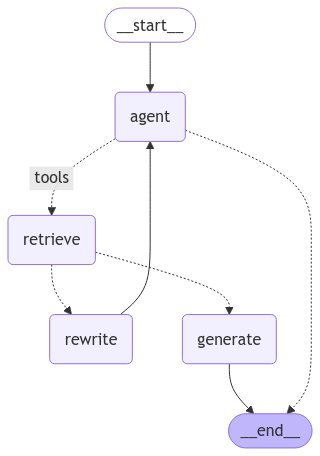

In [21]:
from util import display_graph

display_graph(graph)

In [22]:
query_1 = "agent memory는 무엇인가요?"
query_2 = "Lilian Weng은 agent memory를 어떤 것에 비유했나요?"

In [23]:
import pprint

inputs = { "messages": [("user", query_1)]}

for output in graph.stream(inputs, {"recursion_limit":10}):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("-----")
        print(value)
    print("\n-----\n")

---CALL AGENT---
Output from node 'agent':
-----
{'messages': [AIMessage(content='"Agent memory"는 인공지능 에이전트가 과거의 경험이나 정보를 저장하고 활용할 수 있는 능력을 의미합니다. 이는 에이전트가 이전의 상호작용, 학습한 지식, 또는 특정 상황에서의 결정을 기억하고, 이를 바탕으로 미래의 행동이나 결정을 개선하는 데 도움을 줍니다.\n\n에이전트 메모리는 다음과 같은 몇 가지 주요 기능을 가질 수 있습니다:\n\n1. **경험 저장**: 에이전트는 과거의 경험을 저장하여 유사한 상황에서 더 나은 결정을 내릴 수 있습니다.\n2. **지식 활용**: 에이전트는 저장된 지식을 활용하여 문제를 해결하거나 질문에 답할 수 있습니다.\n3. **상황 인식**: 에이전트는 이전의 상호작용을 기억함으로써 사용자나 환경에 대한 인식을 높일 수 있습니다.\n4. **적응성**: 에이전트는 메모리를 통해 새로운 정보를 학습하고, 이를 바탕으로 행동을 조정할 수 있습니다.\n\n이러한 메모리 기능은 특히 대화형 AI, 로봇, 게임 AI 등 다양한 분야에서 중요한 역할을 합니다.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c'}, id='run-9d50f32d-4b9c-4439-b1ca-f66f691d42ff-0')]}

-----



In [26]:
inputs = { "messages": [("user", query_2)]}

for output in graph.stream(inputs, {"recursion_limit":10}):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("-----")
        print(value)
    print("\n-----\n")

---CALL AGENT---
Output from node 'agent':
-----
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_EtgUio4Gr7kxM2ak0QNQOW2X', 'function': {'arguments': '{"query":"agent memory"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c'}, id='run-df688d20-c5e0-477a-8d00-48dcbfb52a9e-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'agent memory'}, 'id': 'call_EtgUio4Gr7kxM2ak0QNQOW2X', 'type': 'tool_call'}])]}

-----

----CHECK RELEVANCE----


/home/user/langchain-kr/myenv/lib/python3.11/site-packages/langgraph/graph/graph.py:95: UserWarning: WARNING! mode is not default parameter.
                mode was transferred to model_kwargs.
                Please confirm that mode is what you intended.
  result = self.path.invoke(value, config)
/home/user/langchain-kr/myenv/lib/python3.11/site-packages/langchain_openai/chat_models/base.py:1362: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/home/user/langchain-kr/myenv/lib/python3.11/site-packages/langchain_openai/chat_models/base.py:1375: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. 

TypeError: Completions.create() got an unexpected keyword argument 'mode'